<a href="https://colab.research.google.com/github/adaptive-learning/adaptive-programming-research/blob/master/analysis/performance/input_data_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input Data Correlations

*How much various input data for performance measures (such as solving time, or number of executions) correlate with each other? Is it important to take all of them into account, or can we only use a subset of them?*


**This is a work in progress.**


TODO: 
- replicate & rethink & build upon rest of the DP analysis (https://github.com/effa/flocs-thesis/blob/master/analysis/performance-times-vs-clicks.ipynb, https://github.com/effa/flocs-thesis/blob/master/analysis/2018-05-07_performance.ipynb)
- find if I can simply store these colabs to a GH repo

## Imports and helpers

In [0]:
from collections import *
from functools import *
from itertools import *
from math import *
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import widgets

sns.set()
sns.set_context('notebook', font_scale=2)

In [2]:
! git clone https://github.com/adaptive-learning/adaptive-programming-research.git

Cloning into 'adaptive-programming-research'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 1), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [0]:
# Utils.
# TODO: Hide them.
# TODO: Copy the useful ones to the research tools repo (+ docs and tests).

DATA_DIR = './adaptive-programming-research/data/robomission-2018-10-27/'

# TODO: Automatically decode json and list columns (see my/Papi's utils).
def load(name):
    path = DATA_DIR + name + '.csv'
    df = pd.read_csv(path, index_col='id')
    return df

## Data Preparation

In [4]:
ts = load('task_sessions')
# Only consider sessions with an interaction.
ts = ts[ts.time_spent > 0]
# Set maximum spent time to 1h.
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
print('Number of task session:', len(ts))

Number of task session: 57916


In [5]:
snapshots = load('program_snapshots')
edits = snapshots[snapshots.granularity == 'edit']
executions = snapshots[snapshots.granularity == 'execution']
print('Number of snapshots:', len(snapshots))
snapshots.head(2)

Number of snapshots: 967745


,task_session,time,program,granularity,order,correct,time_from_start,time_delta
id,,,,,,,,
9,3,2017-11-10T12:19:58.349785Z,f,edit,1,NaN,3,3
10,3,2017-11-10T12:20:00.225268Z,f,execution,1,True,4,4


In [6]:
# Data imputation.

# Number of edits and executions for each task session.
ts['edits'] = edits.groupby('task_session').program.count()
ts.edits = ts.edits.fillna(0)
ts['executions'] = executions.groupby('task_session').program.count()
ts.executions = ts.executions.fillna(0)



# Extra-thinking actions. Motivation here is to account for the time
# student spends on extra thinking without building the program,
# but make it crude enough to neglect differences cause by individual
# speeds and devices.
def time_to_thinking(time, time_per_thinking=5, cap=5):
    # If you think for more than 5 seconds -> 1 extra thinking.
    # If you think for more than 5^k seconds -> k extra-thinkings.
    # Maximum #thinkings is 5 and you need to think for nearly an hour to get this.
    return min(cap, floor(log(time, time_per_thinking)) if time > 0 else 0)

# Current logs don't include time delta from any last action
# (only from the action of the same granularity).
# TODO: Improve logs to include this attribute.
def to_delta(times):
    deltas = times.diff()
    deltas.iat[0] = times.iat[0]  # diff() puts NaN in the first row.
    return deltas

prev_action_delta = snapshots.groupby('task_session').time_from_start.transform(to_delta)
snapshots['thinkings'] = prev_action_delta.apply(time_to_thinking)
ts['thinkings'] = snapshots.groupby('task_session').thinkings.sum()

# Precompute log-transformed features.
ts['log_time'] = ts.time_spent.apply(np.log)
ts['log_edits'] = (ts.edits + 1).apply(np.log)
ts['log_executions'] = (ts.executions + 1).apply(np.log)
ts['log_thinkings'] = (ts.thinkings + 1).apply(np.log) # Not clear if it makes sense (this is already a sum of log-and-capped times).
ts.head()

,student,task,solved,start,end,time_spent,edits,executions,thinkings,log_time,log_edits,log_executions,log_thinkings
id,,,,,,,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,0.0,0.0,3,4.127134,0.000000,0.000000,1.386294
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,6.0,1.0,7,4.143135,1.945910,0.693147,2.079442
13,29,8,True,2017-11-10T12:24:07.602156Z,2017-11-10T12:24:24.986604Z,17,5.0,1.0,0,2.833213,1.791759,0.693147,0.000000
3,29,51,True,2017-11-10T12:19:55.337206Z,2017-11-10T12:20:00.215662Z,4,1.0,1.0,0,1.386294,0.693147,0.693147,0.000000
29,584,51,True,2017-11-12T08:58:45.905092Z,2017-11-12T08:59:22.765583Z,36,1.0,1.0,2,3.583519,0.693147,0.693147,1.098612


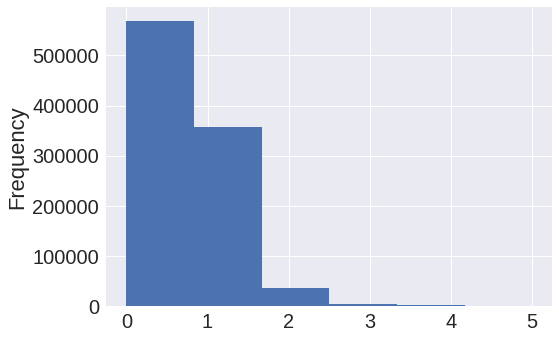

In [9]:
# Verify that thinkigs have a reasonable distribution
# (i.e., there are usually 0 or 1 between actions).
# TODO: Is there a more appropriate graph for this kind of data?
snapshots.thinkings.plot.hist(bins=6)

## Global Correlations

Not only the time, but also the number of edtis, executions and thinkings have significantly skewed distributions:

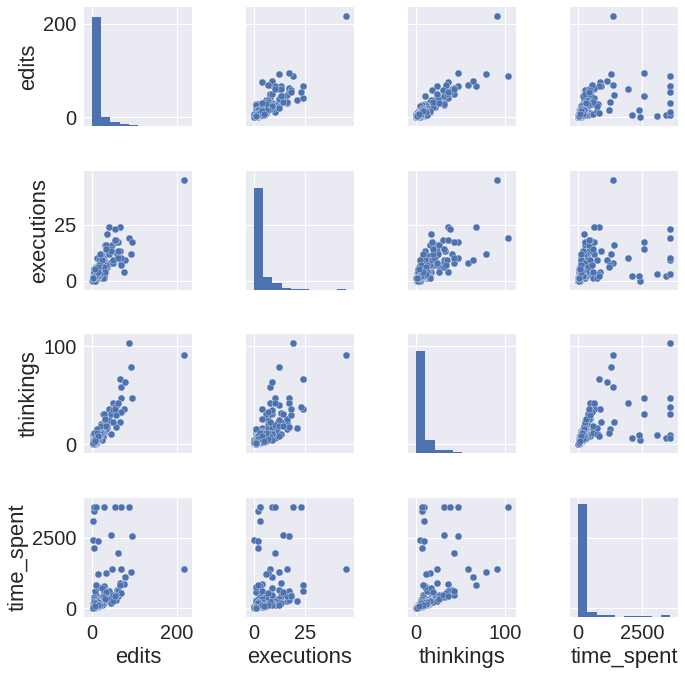

In [46]:
#@title Distributions and relationships between various input data (sample)
ts_sample = ts.sample(500)
g = sns.pairplot(ts_sample, vars=['edits', 'executions', 'thinkings', 'time_spent'])
#g.fig.suptitle('Original features');

Log-transformed features have more symetric distributions. We can observe that they correlate with each other:

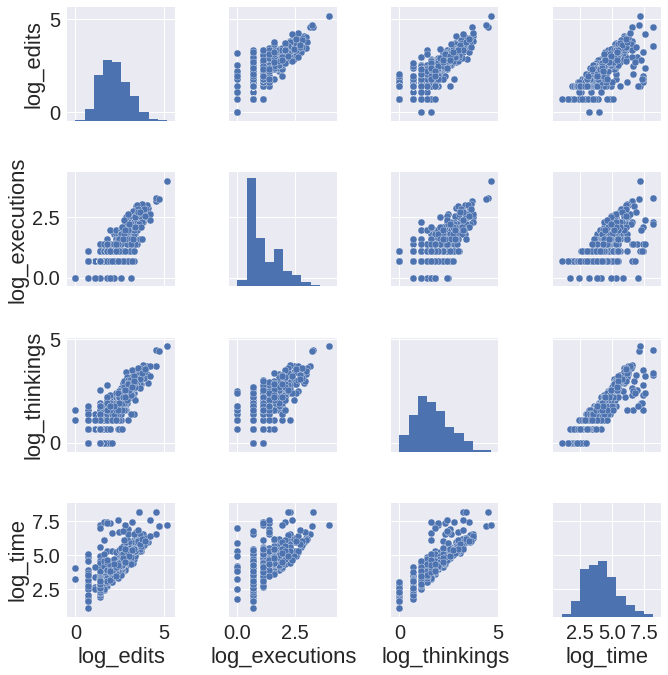

In [45]:
#@title Distributions and relationships between log-transformed input data (sample)
ts_sample = ts.sample(500)
g = sns.pairplot(ts_sample, vars=['log_edits', 'log_executions', 'log_thinkings', 'log_time'])

---


**When aggregated across all tasks, various input data (such as log-edits and log-time) are highly correlated (except for the raw time before log-transformation).**

---





,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlations: original features


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

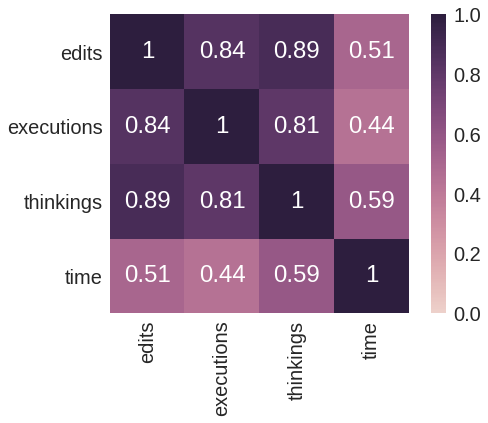

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlations: log-transformed features


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

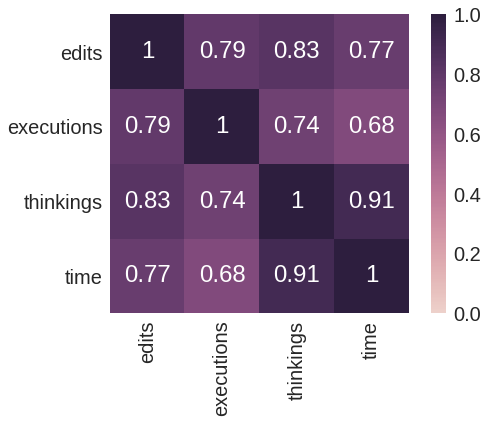

<IPython.core.display.Javascript object>

In [27]:
#@title Global correlations between various input data (left: original, right: log-transformed)
def show_corrs(corrs, save_as=None):
    cmap = sns.cubehelix_palette(as_cmap=True)
    ax = sns.heatmap(corrs, vmin=0, vmax=1, annot=True,
                     square=True, cmap=cmap)


grid = widgets.Grid(2, 2, header_row=True)
with grid.output_to(0, 0):
    print('Correlations: original features')
with grid.output_to(1, 0):
    input_data = pd.DataFrame(OrderedDict(
        edits=ts.edits,
        executions=ts.executions,
        thinkings=ts.thinkings,
        time=ts.time_spent,
    ))
    corrs = input_data.corr()
    show_corrs(corrs)

with grid.output_to(0, 1):
    print('Correlations: log-transformed features')
with grid.output_to(1, 1):
    input_data = pd.DataFrame(OrderedDict(
        edits=ts.log_edits,
        executions=ts.log_executions,
        thinkings=ts.log_thinkings,
        time=ts.log_time,
    ))
    corrs = input_data.corr()
    show_corrs(corrs)

## Correlations Aggregated by Tasks

TODO

## Correlations Aggregated by Problem Sets

- e.g.: scatterplot matrix with the individual relationships, colored by the problem set

## Correlations Aggregated by Users

TODO

## Correlations Aggregated by Populations

TODO (use day+time as a super-crude proxy for students?)

- e.g.: scatterplot matrix with the individual relationships, colored by the type of the student